In [ ]:
!pip install kornia scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 105.2 MB/s eta 0:00:00


In [ ]:
import torch
import kornia
import numpy as np
import matplotlib.pyplot as plt
import skimage
import cv2

In [ ]:
IMG_PATH = "/content/frame000001.jpg"

Text(0.5, 1.0, 'Input')

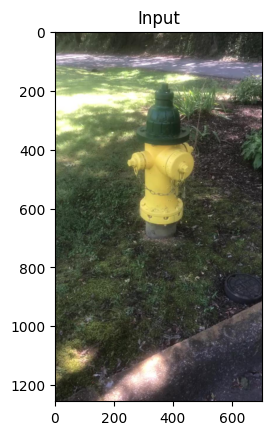

In [ ]:
img_bgr = cv2.imread(IMG_PATH)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
# img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_t = torch.from_numpy(img_rgb).float().permute(2,0,1).unsqueeze(0) / 255. # [1,3,H,W]

plt.imshow(img_rgb)
plt.title("Input")


Sobel Edge Map (Kornia)

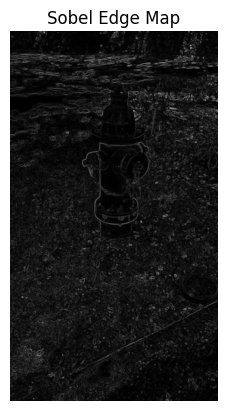

In [ ]:
sobel = kornia.filters.sobel(img_t)
sobel_mag = sobel.norm(dim=1)[0].cpu().numpy()

plt.imshow(sobel_mag, cmap="gray")
plt.title("Sobel Edge Map")
plt.axis("off")

np.save("sobel_edges.npy", sobel_mag) # We can save per-pixel information as numpy arrays.


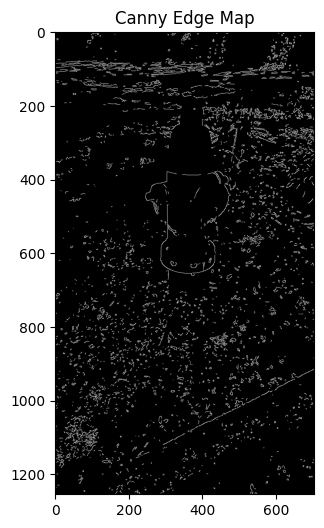

In [ ]:

img = cv2.imread(IMG_PATH, cv2.IMREAD_GRAYSCALE)
canny = cv2.Canny(img, 150, 200) # Two thresholds are arbitrarily chosen - needs further research.

plt.figure(figsize=(6,6))
plt.title("Canny Edge Map")
plt.imshow(canny, cmap='gray')
plt.show()


MiDaS test through Torch Hub

In [ ]:
!pip install timm

From https://pytorch.org/hub/intelisl_midas_v2/

In [ ]:
model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)

In [ ]:
midas = torch.hub.load("intel-isl/MiDaS", model_type)

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_large_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_large_384.pt


100%|██████████| 1.28G/1.28G [00:08<00:00, 172MB/s]


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [ ]:
img = cv2.imread(IMG_PATH)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

In [ ]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

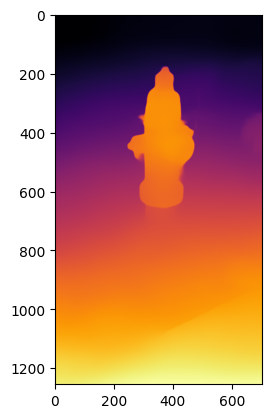

In [ ]:
depth = prediction
depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8) # Normalising to a 0-1 scale
plt.imshow(depth_norm, cmap="inferno")


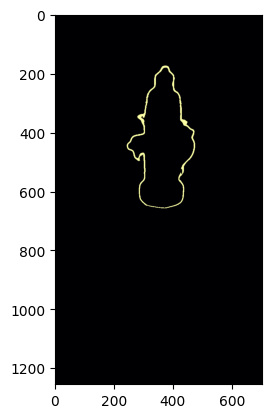

In [ ]:
depth_f =  depth.squeeze().cpu().numpy().astype(np.float32)

# Sobel requires npy arrays
dx = cv2.Sobel(depth_f, cv2.CV_32F, 1, 0, ksize=3) # Compute depth gradients - if changes quickly, likely to be an object boundary
dy = cv2.Sobel(depth_f, cv2.CV_32F, 0, 1, ksize=3)
depth_grad = np.sqrt(dx*dx + dy*dy) # Depth edge strength map
depth_grad_norm = depth_grad / (depth_grad.max() + 1e-8)

thr = 0.05  # Tunable threshold, needs to be quite low to detect in this example.
depth_edge_mask = (depth_grad_norm > thr).astype(np.float32)

plt.imshow(depth_edge_mask, cmap="inferno")


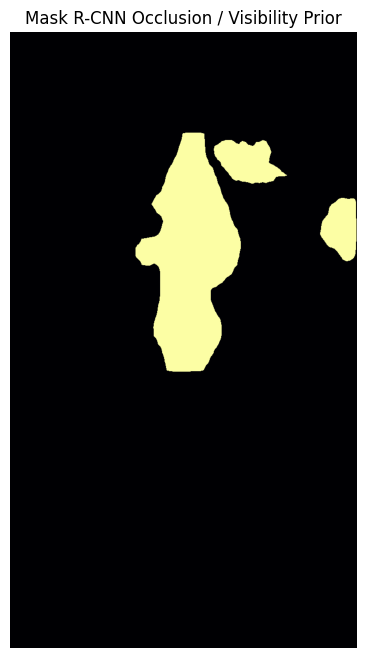

In [ ]:
# occlusion/visibility prior
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.detection.maskrcnn_resnet50_fpn(pretrained=True)
model.eval().to(device)

img = Image.open(IMG_PATH).convert("RGB")
transform = transforms.Compose([
    transforms.ToTensor(),
])
img_t = transform(img).to(device)

with torch.no_grad():
    outputs = model([img_t])[0]

masks = outputs['masks']  # shape: [num_instances, 1, H, W]
masks = (masks > 0.5).float()  # thresholded to binary

panoptic_mask = torch.sum(masks, dim=0).squeeze()
panoptic_mask = (panoptic_mask > 0).float().cpu().numpy()
plt.figure(figsize=(8,8))
plt.imshow(panoptic_mask, cmap="inferno")
plt.title("Mask R-CNN Occlusion / Visibility Prior")
plt.axis("off")
plt.show()

np.save("occlusion_mask.npy", panoptic_mask)


## Segmentation (SAM: Facebook Model)

In [ ]:
!nvidia-smi

Wed Nov 19 15:17:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P8             11W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision==0.23.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.5/151.5 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 130.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.9 MB/s eta 0:00:00


In [ ]:
%cd root

/root


In [ ]:
!mkdir -p /weights


^C


In [ ]:
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P /weights

In [ ]:
import os

CHECKPOINT_PATH = os.path.join("weights", "sam_vit_h_4b8939.pth")
print(CHECKPOINT_PATH, "; exist:", os.path.isfile(CHECKPOINT_PATH))

weights/sam_vit_h_4b8939.pth ; exist: False


In [ ]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'
!wget -q 'https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth'



  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-znz0rkcu
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-znz0rkcu
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


## Detectron2

In [ ]:
!python -m pip install pyyaml==5.1
# Detectron2 has not released pre-built binaries for the latest pytorch (https://github.com/facebookresearch/detectron2/issues/4053)
# so we install from source instead. This takes a few minutes.
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install pre-built detectron2 that matches pytorch version, if released:
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/{CUDA_VERSION}/{TORCH_VERSION}/index.html

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 9.1 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-6u1imn_f
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-6u1imn_f
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0
torch:  2.8 ; cuda:  cu126
detectron2: 0.6


In [ ]:
from detectron2.utils.logger import setup_logger
setup_logger()
import cv2

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

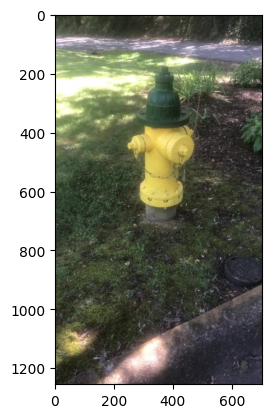

In [ ]:
im = cv2.imread("/content/frame000001.jpg")
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")

In [28]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

In [29]:
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[11/19 16:29:56 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


model_final_f10217.pkl: 178MB [00:00, 209MB/s]                           


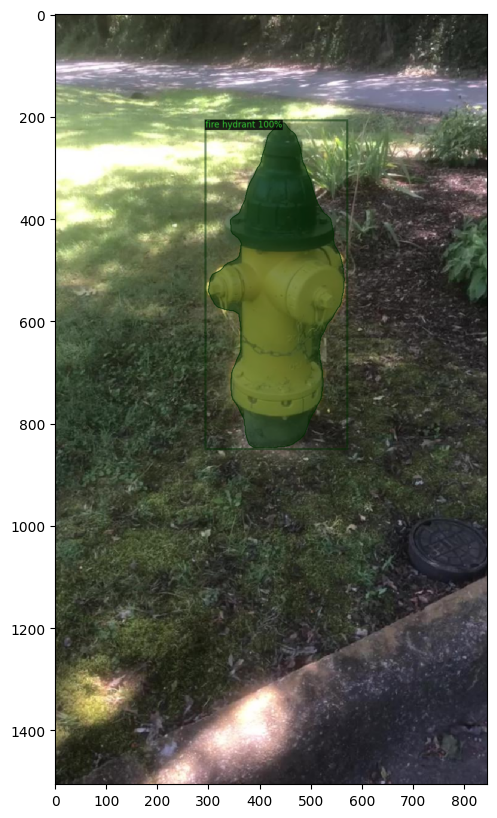

In [30]:
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))